In [1]:
from PIL import Image

image = Image.open("/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM NEW NEW/RESM/20100903_0025_hr_patch_11.jpg")
mode = image.mode
channels = {"L": 1, "RGB": 3, "RGBA": 4, "CMYK": 4}  # Mapping for common modes
num_channels = channels.get(mode, "Unknown")
print(f"Number of channels: {num_channels}")


Number of channels: 1


In [2]:
import os 
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
import random
from datetime import datetime


from loop import train_loop
from dcnet import DCNet

In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, lr_transform=None, hr_transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = os.listdir(lr_dir)
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.lr_images[idx])

        lr_image = Image.open(lr_image_path).convert("L").resize((64, 64))  # Resize to 64x64
        hr_image = Image.open(hr_image_path).convert("L").resize((256, 256))  # Resize to 256x256

        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)
        if self.hr_transform:
            hr_image = self.hr_transform(hr_image)

        return {'image': lr_image, 'label': hr_image}

In [4]:
def dataloaders(train_dataset, val_dataset, batch_size=8): # setting the batch size to 2
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def setup_training(model, device, train_loader, val_loader, epochs=100, patience=10):
    # Ensure the model is moved to the correct device
    model = model.to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 45, 65, 85], gamma=0.5)

    # Initialize loss function
    criterion = nn.L1Loss()

    # Prepare output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join("models", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    # Start training loop
    train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=epochs
    )


In [5]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is being used. Device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU instead of GPU.")

GPU is being used. Device: NVIDIA RTX A6000


In [6]:
from torchinfo import summary


CUDA is available!
Number of available GPUs: 1
Current device: 0
Device name: NVIDIA RTX A6000
Layer (type:depth-idx)                                                 Input Shape               Output Shape              Param #                   Trainable
DCNet                                                                  [1, 1, 64, 64]            [1, 1, 256, 256]          --                        True
├─ShallowFeatureExtractor: 1-1                                         [1, 1, 64, 64]            [1, 180, 64, 64]          --                        True
│    └─Conv2d: 2-1                                                     [1, 1, 64, 64]            [1, 180, 64, 64]          1,620                     True
│    └─Sequential: 2-2                                                 [1, 180, 64, 64]          [1, 180, 64, 64]          --                        True
│    │    └─ResidualBlock: 3-1                                         [1, 180, 64, 64]          [1, 180, 64, 64]          --     

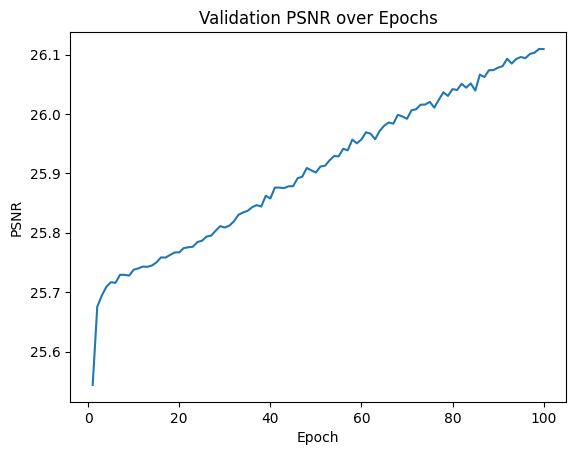

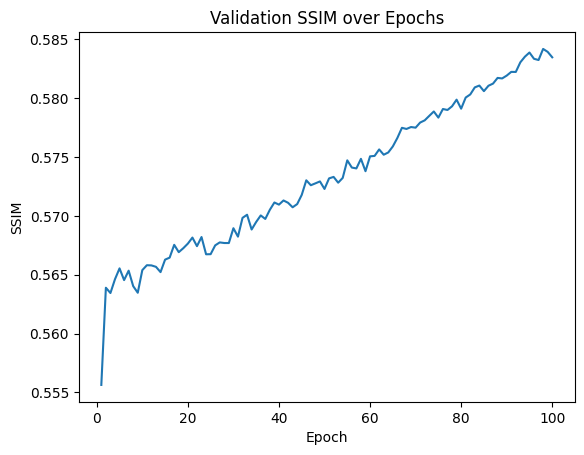

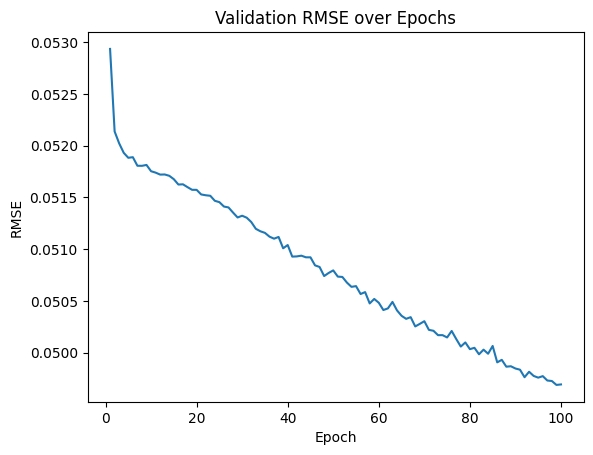

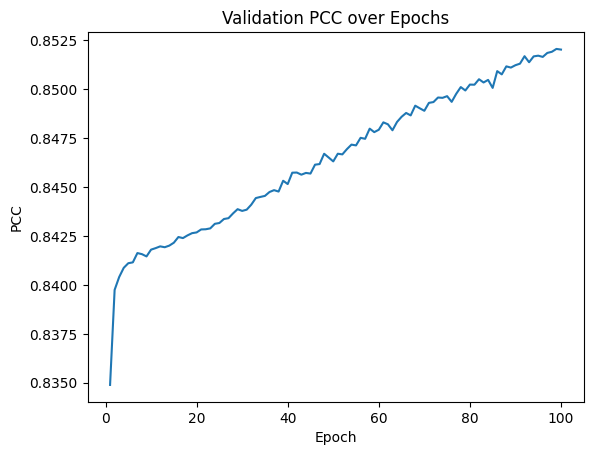

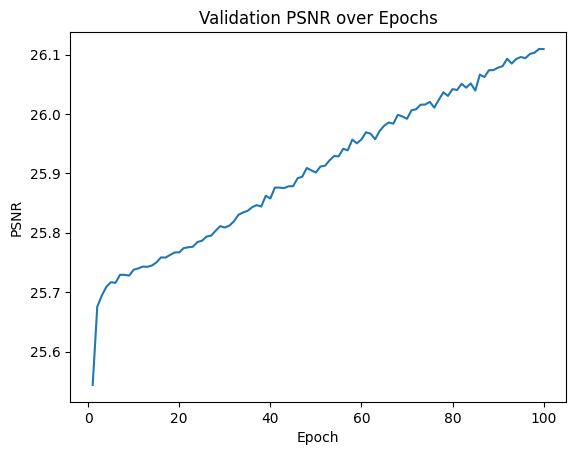

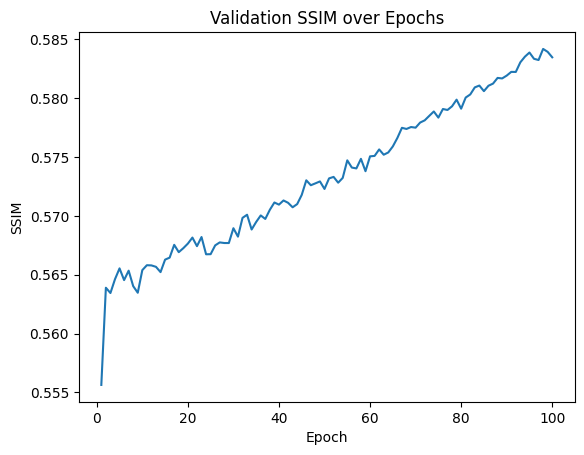

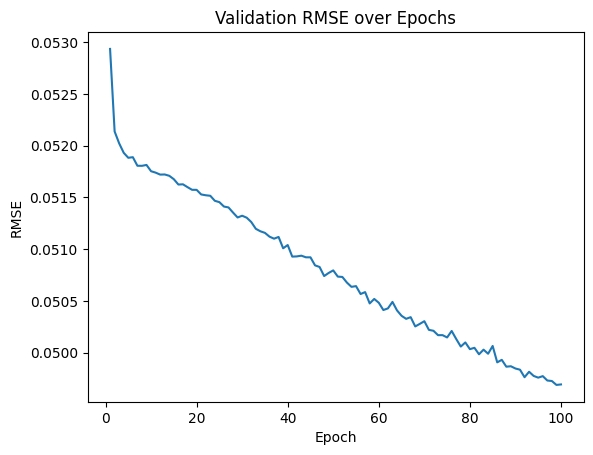

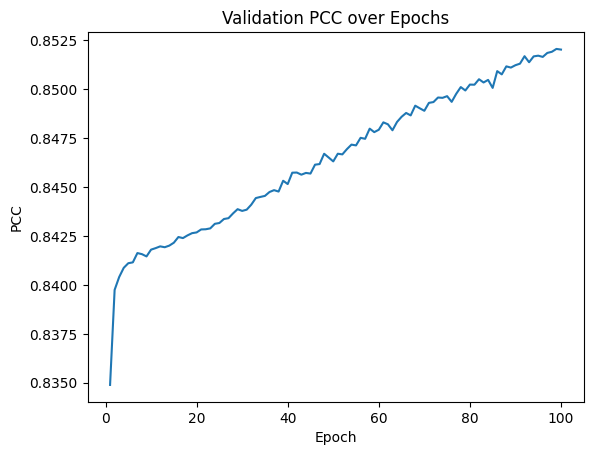

In [ ]:
def main():
    if torch.cuda.is_available():
        print("CUDA is available!")
        print(f"Number of available GPUs: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    else:
        print("CUDA is not available.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DCNet(
        in_channels=1,
        channels=180,
        rg_depths=[2,2,2,2,2],   # 5 RGs × 2 DCBs = 10 blocks
        num_heads=[6,6,6,6,6],
        mlp_ratio=2.0,
        window_size=(4,4),
        scale_factors=[4],
        out_channels=1
    )

    transform_lr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,), (1.0,))
    ])

    transform_hr = transforms.Compose([
        transforms.ToTensor(),

    ])

    # Load the dataset
    lr_dir = "/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches low res"
    hr_dir = "/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches"

    full_dataset = SuperResolutionDataset(
        lr_dir=lr_dir,
        hr_dir=hr_dir,
        lr_transform=transform_lr,
        hr_transform=transform_hr
    )


    # Splitting the dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader, val_loader = dataloaders(train_dataset, val_dataset, batch_size=1)

    print(summary(
    model, 
    input_size=(1, 1, 64, 64),  # Batch size = 1, Channels = 1, Height = 64, Width = 64
    device=device, 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    depth=4
    ))
    setup_training(model, device, train_loader, val_loader)

main()


In [8]:
!nvidia-smi

Thu Jun 12 19:03:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:1A:00.0  On |                  Off |
| 74%   81C    P2             117W / 300W |   7437MiB / 49140MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Testing

In [10]:
model = DCNet(
        in_channels=1,
        channels=180,
        rg_depths=[2,2,2,2,2],   # 5 RGs × 2 DCBs = 10 blocks
        num_heads=[6,6,6,6,6],
        mlp_ratio=2.0,
        window_size=(4,4),
        scale_factors=[4],
        out_channels=1
    ).to(device)
model.load_state_dict(torch.load("/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/anubhav/DCNET/Resolution_Enhancement_DCNET-main/Resolution_Enhancement_DCNET/Architecture/models/20250611_173045/model_epoch100.pth"))
# model.eval()


/tmp/ipykernel_122505/2460794555.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user

<All keys matched successfully>

In [14]:
# from predict import prediction
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,], std=[1,])
    # transforms.Lambda(lambda x: x * 255.0),
])

def prediction(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image)
    return output.squeeze(0).cpu()


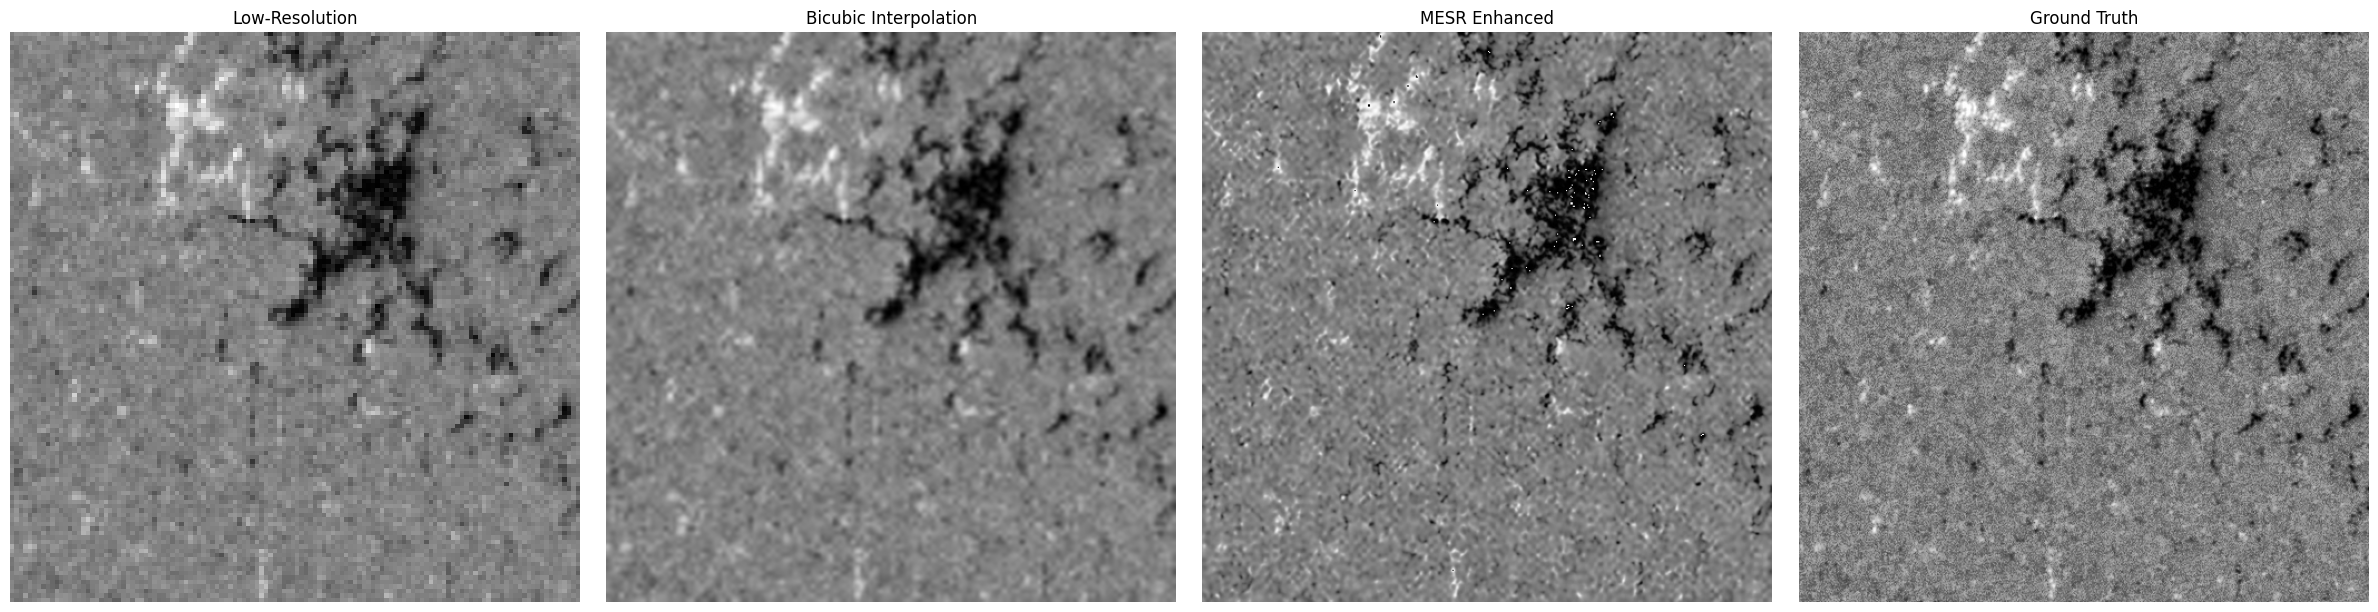

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import cv2

# Example usage with visualization
low_res_image_path = '/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM NEW NEW/RESM/20100903_0025_hr_patch_11.jpg'  # Replace with your low-res image path
hr_image_path = '/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches/20100903_0025_hr_patch_11.jpg'  # Replace with your high-res image path

# Get SRCNN/MESR enhanced image
predicted_image_tensor = prediction(model, low_res_image_path)
predicted_image_pil = transforms.ToPILImage()(predicted_image_tensor)  # Convert tensor to PIL image
predicted_image_np = np.array(predicted_image_pil)  # Convert PIL to NumPy array

# Load low-resolution image
low_res_pil = Image.open(low_res_image_path).convert('L')
low_res_np = np.array(low_res_pil)

# Load ground truth high-resolution image
hr_pil = Image.open(hr_image_path).convert('L')
hr_np = np.array(hr_pil)

# Perform bicubic interpolation
bicubic_np = cv2.resize(low_res_np, (predicted_image_np.shape[1], predicted_image_np.shape[0]), interpolation=cv2.INTER_CUBIC)

# Visualization using matplotlib
plt.figure(figsize=(24, 6))  # Adjust figure size as needed

# Subplot 1: Low-Resolution Image
plt.subplot(1, 4, 1)
plt.imshow(low_res_np, cmap='gray')
plt.title('Low-Resolution')
plt.axis('off')

# Subplot 2: Bicubic Interpolation Image
plt.subplot(1, 4, 2)
plt.imshow(bicubic_np, cmap='gray')
plt.title('Bicubic Interpolation')
plt.axis('off')

# Subplot 3: MESR Enhanced Image
plt.subplot(1, 4, 3)
plt.imshow(predicted_image_np, cmap='gray')
plt.title('MESR Enhanced')
plt.axis('off')

# Subplot 4: Ground Truth (High-Resolution) Image
plt.subplot(1, 4, 4)
plt.imshow(hr_np, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optionally save the images
predicted_image_pil.save('path_to_save_predicted_image.png')
bicubic_pil = Image.fromarray(bicubic_np)
bicubic_pil.save('path_to_save_bicubic_image.png')
hr_pil.save('path_to_save_hr_image.png')


In [ ]:
predicted_image_tensor

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]])